In [5]:
import pandas as pd
import numpy as np
import re
import string
import random

import matplotlib.pyplot as plt # type: ignore
#! python -m spacy download en_core_web_sm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
# ! pip install keras
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler


import gensim # type: ignore
from gensim.models import Word2Vec # type: ignore

In [6]:
df = pd.read_csv("C:/Users/KIIT0001/Desktop/Oasis Infobyte Data Analytics/Sentiment Analysis/Twitter_Data.csv")
df.head()


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [8]:
df.category.value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [9]:
print(df['clean_text'][19])
print(df['clean_text'][91])

didn’ write chowkidar does mean ’ anti modi try visit the plz not all who haven’ used are anti 
dont forget petrol prices have risen ₹ modi government when gulf prices were going down ाेशबचा 


In [10]:
any_nan_in_A = df['clean_text'].isna().any()
print(any_nan_in_A)


True


In [11]:
df['clean_text'] = df['clean_text'].fillna('')

In [12]:
df = df.dropna()
any_nan_in_A = df['category'].isna().any()
print(any_nan_in_A)

False


In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'^[^ ]<.*?>|&([a-z0-9]+|#[0-9]\"\'\“{1,6}|#x[0-9a-f]{1,6});[^A-Za-z0-9]+')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)


# Applying helper functions
df1 = df.copy()
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_URL(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_emoji(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_html(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_punct(x))
df1['clean_text'] = df1['clean_text'].apply(lambda x: remove_quotes(x))
df1['clean_text'] = df1['clean_text'].str.lower()


print(df1['clean_text'][19]),
print(df1['clean_text'][91])

didn write chowkidar does mean  anti modi try visit the plz not all who haven used are anti 
dont forget petrol prices have risen  modi government when gulf prices were going down  


In [14]:
df2 =df1.copy()
df2 = df1[df1.category != 0.0]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107760 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107760 non-null  object 
 1   category    107760 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [15]:
df2 = df2.drop_duplicates(subset=['clean_text'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107635 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  107635 non-null  object 
 1   category    107635 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [17]:
df_test = df3.copy()
category = df_test['category']
mapped_labels = [0 if label == -1 else 1 for label in category]
df_test['category'] = mapped_labels
df_test.head()

,clean_text,category
0,when modi promised minimum government maximum ...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
8,with upcoming election india saga going import...,1


In [18]:
display(df_test.describe())

# Print the info
print(df_test.info())

,category
count,107635.000000
mean,0.670358
std,0.470085
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 107635 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  107635 non-null  object
 1   category    107635 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.5+ MB
None


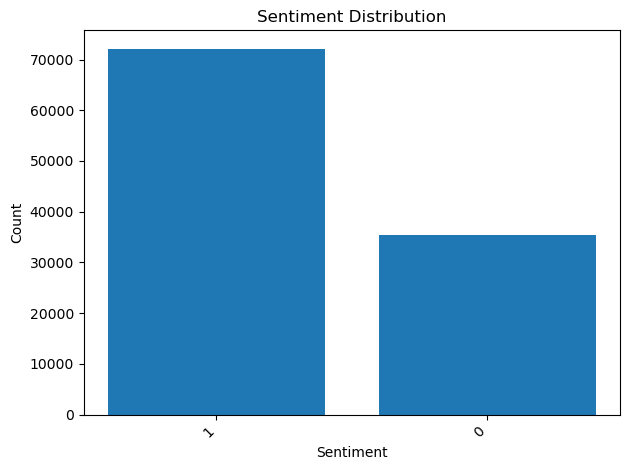

In [19]:
# Calculate sentiment counts
sentiment_counts = df_test['category'].value_counts()

# Get values for x-axis and y-axis
x = sentiment_counts.index.astype(str).to_list()  # Ensure string labels for x-axis
y = sentiment_counts.values.tolist()

# Create the bar chart
plt.bar(x, y)

# Customize the plot
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout for better visibility
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
df4 = df_test.copy()
df4['word_count'] = df_test['clean_text'].apply(lambda x : len(x.split()))
df4['char_count'] = df_test['clean_text'].apply(lambda x : len(x.replace(" ","")))
df4['word_density'] = df4['word_count'] / (df4['char_count'] + 1)

df4[['word_count', 'char_count', 'word_density']].head()

,word_count,char_count,word_density
0,33,176,0.186441
2,22,95,0.229167
3,34,179,0.188889
4,14,67,0.205882
8,24,132,0.180451


In [21]:
def plot_distribution_by_category(df, column, start, end, size, category_type):
    # Filter data based on category
    negative_df = df[df['category'] == 0]
    positive_df = df[df['category'] == 1]

    # Define bins for histogram
    bins = np.arange(start, end + size, size)

    # Create subplots with 1 row and 2 columns (for negative, positive)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))  # Adjust figure size as needed

    # Plot histograms for each category in separate subplots
    ax[0].hist(negative_df[column], bins=bins, color='orange', alpha=0.75)
    ax[0].set_title('Negative Tweets')
    ax[0].set_xlabel(f'Tweet Length {category_type}')
    ax[0].set_ylabel('Number of Tweets')

    ax[1].hist(positive_df[column], bins=bins, color='blue', alpha=0.75)
    ax[1].set_title('Positive Tweets')
    ax[1].set_xlabel(f'Tweet Length {category_type}')
    ax[1].set_ylabel('Number of Tweet')

    # Adjust layout to prevent overlap of labels
    plt.tight_layout()

    # Show plot
    plt.show()

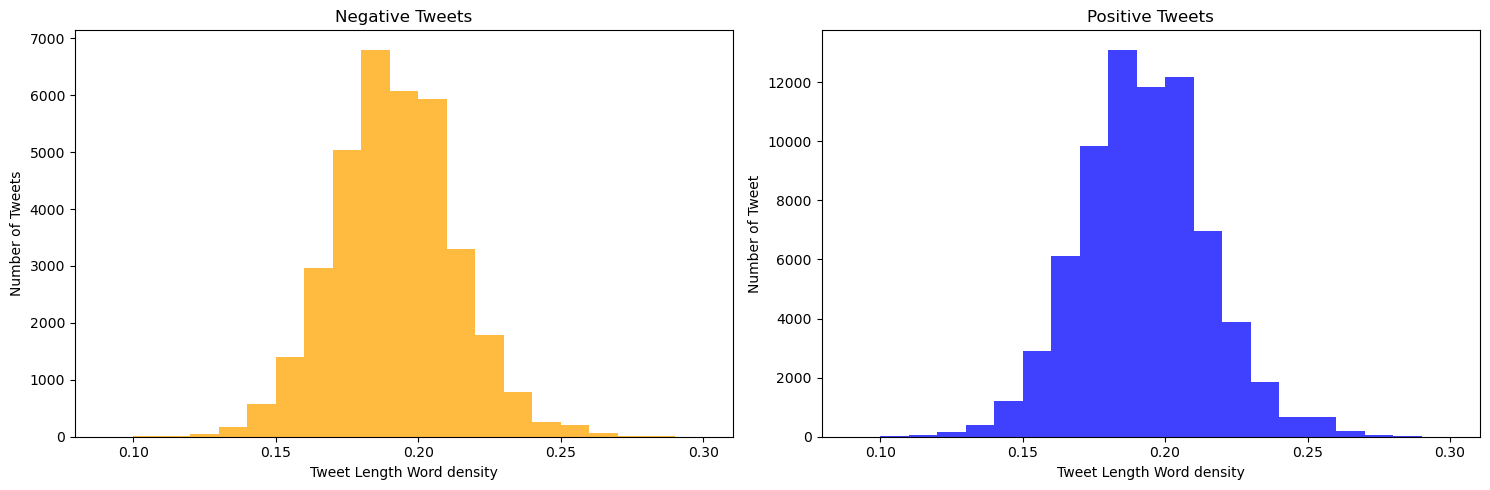

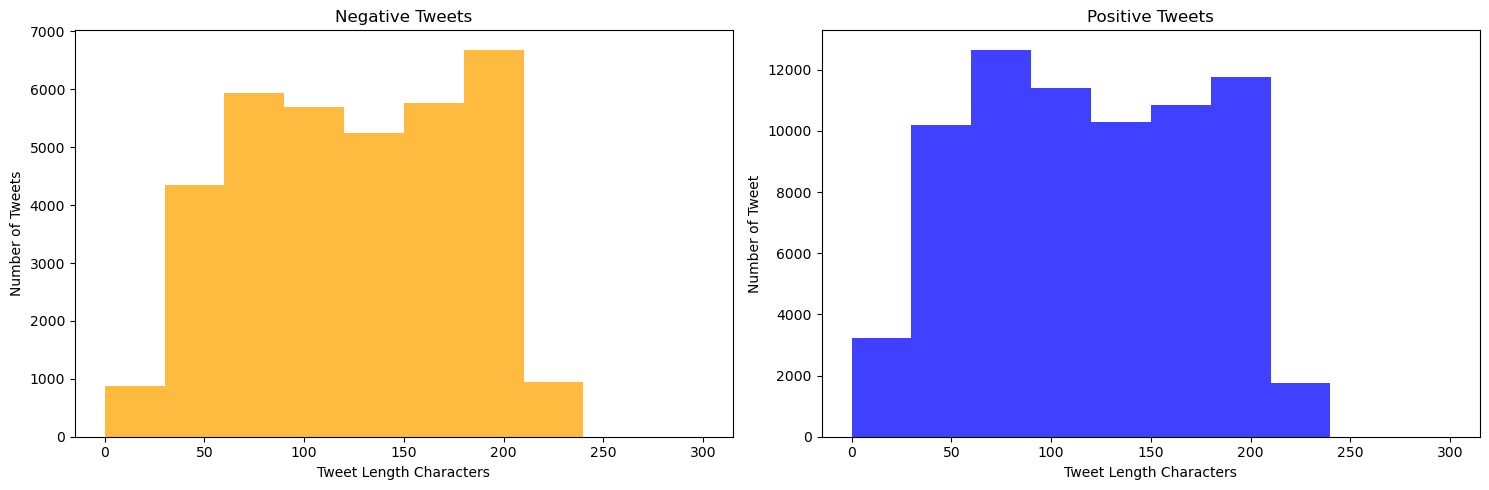

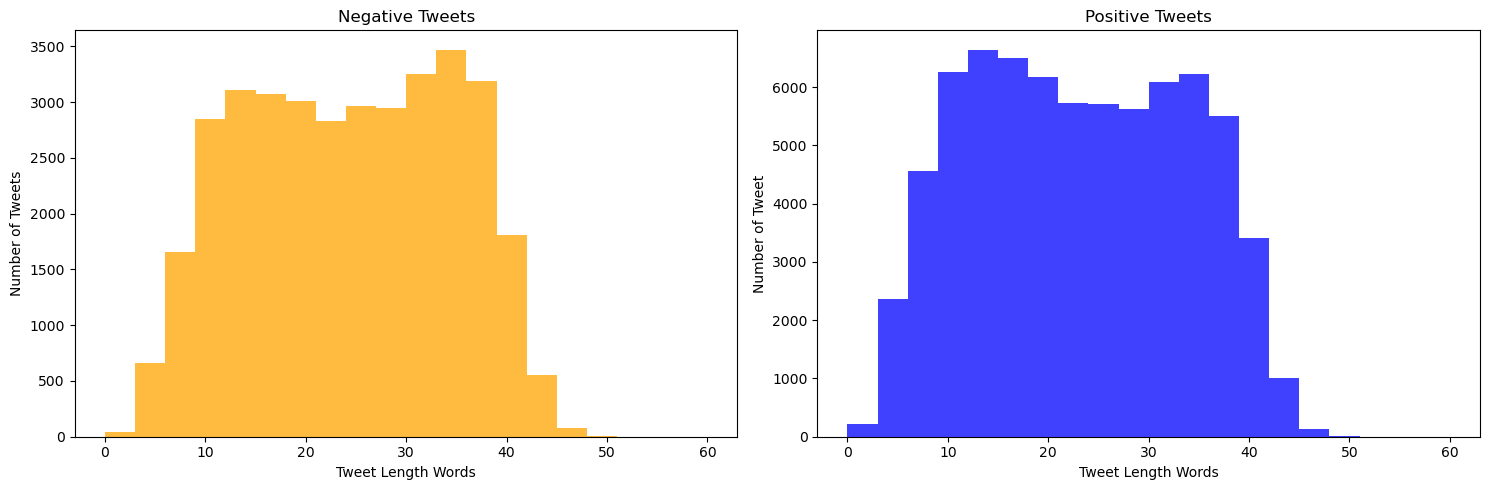

In [26]:
plot_distribution_by_category(df4,'word_density', 0.09, 0.3, .01,'Word density')
plot_distribution_by_category(df4, 'char_count', 0, 300, 30,'Characters')
plot_distribution_by_category(df4, 'word_count', 0, 60, 3,'Words')

In [29]:
positive_tweets = df4[df4['category'] == 1.0]
negative_tweets = df4[df4['category'] == 0.0]
df4.head()

,clean_text,category,word_count,char_count,word_density
0,when modi promised minimum government maximum ...,0,33,176,0.186441
2,what did just say vote for modi welcome bjp t...,1,22,95,0.229167
3,asking his supporters prefix chowkidar their n...,1,34,179,0.188889
4,answer who among these the most powerful world...,1,14,67,0.205882
8,with upcoming election india saga going import...,1,24,132,0.180451


In [35]:
df4.to_csv('refined_tweet_data.csv',encoding = 'utf-8-sig')

In [36]:
X = df4['clean_text']
Y = df4['category']

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify = Y,
                                                    random_state = 34)

In [38]:
#Initialize the tf-id vectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii')

#Using the vectorizer to fit on out training data and testing data
tfidf_train = vectorizer.fit_transform(X_train)
tfidf_test = vectorizer.transform(X_test)
# Create a Majority Class Classifier
majority_classifier = DummyClassifier(strategy="most_frequent")
majority_classifier.fit(tfidf_train, Y_train)

# Predict the majority class for all instances in the test set
y_pred_majority = majority_classifier.predict(tfidf_test)
# Print classification report
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred_majority))


Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7096
           1       0.67      1.00      0.80     14431

    accuracy                           0.67     21527
   macro avg       0.34      0.50      0.40     21527
weighted avg       0.45      0.67      0.54     21527



c:\Users\KIIT0001\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KIIT0001\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KIIT0001\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
import pandas as pd

data = pd.read_csv("C:/Users/KIIT0001/Desktop/Oasis Infobyte Data Analytics/Sentiment Analysis/Twitter_Data.csv")
data.head()


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


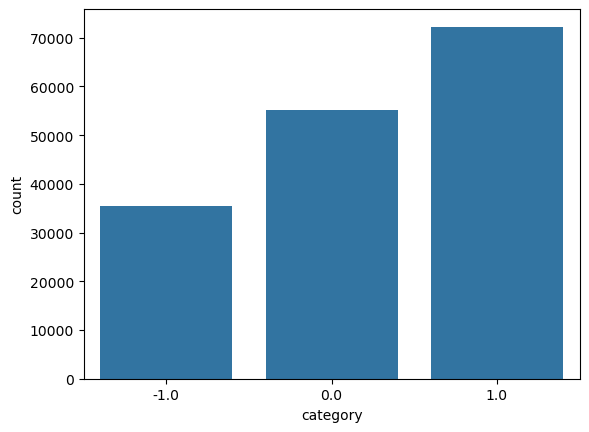

In [44]:
sns.countplot(x='category', data=data)
plt.show()